In [383]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
"""Main training script for Cascaded Nets."""
import argparse
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch
pd.set_option('mode.chained_assignment', None)
from collections import defaultdict
from datasets.dataset_handler import DataHandler
from matplotlib.lines import Line2D
from modules import utils
from scipy import interpolate

In [385]:
# # sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# # pip install latex
# from matplotlib import rc

# rc('text',usetex=True)
# rc('text.latex', preamble='\\usepackage{color}')

In [386]:
def setup_args():
  parser = argparse.ArgumentParser()
  parser.add_argument("--random_seed", type=int, default=42,
                      help="random seed")
  
  # Paths
  parser.add_argument("--experiment_root", type=str, 
                      default='experiments',
                      help="Local output dir")
#   parser.add_argument("--experiment_name", type=str, 
#                       required=True,
#                       help="Experiment name")
  
  # Dataset
#   parser.add_argument("--dataset_root", type=str, required=True,
#                       help="Dataset root")
#   parser.add_argument("--dataset_name", type=str, required=True,
#                       help="Dataset name: CIFAR10, CIFAR100, TinyImageNet")
  parser.add_argument("--split_idxs_root", type=str, default='split_idxs',
                      help="Split idxs root")
  parser.add_argument("--val_split", type=float, default=0.1,
                      help="Validation set split: 0.1 default")
  parser.add_argument("--augmentation_noise_type", type=str, 
                      default='occlusion',
                      help="Augmentation noise type: occlusion")
  parser.add_argument("--batch_size", type=int, default=128,
                      help="batch_size")
  parser.add_argument("--num_workers", type=int, default=2,
                      help="num_workers")
  parser.add_argument('--drop_last', action='store_true', default=False,
                      help='Drop last batch remainder')
  
  # Model
  parser.add_argument("--model_key", type=str, default='resnet18',
                      help="Model: resnet18, resnet34, ..., densenet_cifar")
  parser.add_argument("--train_mode", type=str, 
                      default='baseline',
                      help="Train mode: baseline, ic_only, sdn")
  parser.add_argument('--bn_time_affine', action='store_true', default=False,
                      help='Use temporal affine transforms in BatchNorm')
  parser.add_argument('--bn_time_stats', action='store_true', default=False,
                      help='Use temporal stats in BatchNorm')
  parser.add_argument("--tdl_mode", type=str, 
                      default='OSD',
                      help="TDL mode: OSD, EWS, noise")
  parser.add_argument("--tdl_alpha", type=float, default=0.0,
                      help="TDL alpha for EWS temporal kernel")
  parser.add_argument("--noise_var", type=float, default=0.0,
                      help="Noise variance on noise temporal kernel")
  parser.add_argument("--lambda_val", type=float, default=1.0,
                      help="TD lambda value")
  parser.add_argument('--cascaded', action='store_true', default=False,
                      help='Cascaded net')
  parser.add_argument("--cascaded_scheme", type=str, default='parallel',
                      help="cascaded_scheme: serial, parallel")
  parser.add_argument("--init_tau", type=float, default=0.01,
                      help="Initial tau valu")
  parser.add_argument("--target_IC_inference_costs", nargs="+", type=float, 
                      default=[0.15, 0.30, 0.45, 0.60, 0.75, 0.90],
                      help="target_IC_inference_costs")
  parser.add_argument('--tau_weighted_loss', action='store_true', default=False,
                      help='Use tau weights on IC losses')
  
  
  # Optimizer
  parser.add_argument("--learning_rate", type=float, default=0.1,
                      help="learning rate")
  parser.add_argument("--momentum", type=float, default=0.9,
                      help="momentum")
  parser.add_argument("--weight_decay", type=float, default=0.0005,
                      help="weight_decay")
  parser.add_argument('--nesterov', action='store_true', default=False,
                      help='Nesterov for SGD')
  parser.add_argument('--normalize_loss', action='store_true', default=False,
                      help='Normalize temporal loss')
  
  # LR scheduler
  parser.add_argument("--lr_milestones", nargs="+", type=float, 
                      default=[60, 120, 150],
                      help="lr_milestones")
  parser.add_argument("--lr_schedule_gamma", type=float, default=0.2,
                      help="lr_schedule_gamma")
  
  # Other
  parser.add_argument('--use_cpu', action='store_true', default=False,
                      help='Use cpu')
  parser.add_argument("--device", type=int, default=0,
                      help="GPU device num")
  parser.add_argument("--n_epochs", type=int, default=150,
                      help="Number of epochs to train")
  parser.add_argument("--eval_freq", type=int, default=10,
                      help="eval_freq")
  parser.add_argument("--save_freq", type=int, default=5,
                      help="save_freq")
  parser.add_argument('--keep_logits', action='store_true', default=False,
                      help='Keep logits')
  parser.add_argument('--debug', action='store_true', default=False,
                      help='Debug mode')
  
  args = parser.parse_args("")
  
  # Flag check
  if args.tdl_mode == 'EWS':
    assert args.tdl_alpha is not None, 'tdl_alpha not set'
  elif args.tdl_mode == 'noise':
    assert args.noise_var is not None, 'noise_var not set'
    
  return args

In [594]:
casc_seq_color = np.array((54,129,179)) / 255.

In [388]:
figs_root = "figs/distillation"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [389]:
args = setup_args()

args.dataset_root = '/hdd/mliuzzolino/datasets'
args.experiment_root = '/home/mliuzzolino/experiment_output'
  
# Set required flags|
args.dataset_name = 'CIFAR100'  # CIFAR10, CIFAR100, ImageNet2012
args.model_key = 'resnet18_small'  # resnet18, resnet18_small
args.dataset_key = 'test'  # val, test
if args.dataset_name == "ImageNet2012":
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
elif "cifar" in args.dataset_name.lower():
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
else:
  print("TinyImageNet not implemented yet!")
  
args.val_split = 0.1
args.test_split = 0.1
args.split_idxs_root = "/hdd/mliuzzolino/split_idxs"
args.tdl_mode = 'OSD'  # OSD, EWS
args.tau_weighted_loss = True
args.random_seed = 42

In [390]:
# Make reproducible
utils.make_reproducible(args.random_seed)

Making reproducible on seed 42


In [391]:
# Data Handler
data_dict = {
    "dataset_name": args.dataset_name,
    "data_root": args.dataset_root,
    "val_split": args.val_split,
    "test_split": args.test_split,
    "split_idxs_root": args.split_idxs_root,
    "noise_type": args.augmentation_noise_type,
    "load_previous_splits": True,
    "imagenet_params": {
      "target_classes": ["terrier"],
      "max_classes": 10,
    }
}
data_handler = DataHandler(**data_dict)

Setting split idxs root to /hdd/mliuzzolino/split_idxs/CIFAR100
Loading CIFAR100 train data...
Files already downloaded and verified
Loading previous splits from /hdd/mliuzzolino/split_idxs/CIFAR100/10-90_val_split.json
45,000 train examples loaded.
5,000 val examples loaded.
50,000 dev examples loaded.
Loading CIFAR100 test data...
Files already downloaded and verified
10,000 test examples loaded.


In [392]:
# Set Loaders
test_loader = data_handler.build_loader(args.dataset_key, args)

In [393]:
# Set experiment root
exp_root = os.path.join(args.experiment_root,
                        args.experiment_name,
                        'experiments')
exp_root = f"/hdd/mliuzzolino/cascaded_distillation_nets/{args.experiment_name}/experiments"

# Find exp paths
exp_paths = np.sort(glob.glob(f'{exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))


# Large model paths
large_exp_name = args.experiment_name.replace("_small", "")
large_exp_root = os.path.join(
  args.experiment_root,
  large_exp_name,
  'experiments'
)
large_exp_root = f"/hdd/mliuzzolino/cascaded_distillation_nets/{large_exp_name}/experiments"
large_exp_paths = np.sort(glob.glob(f'{large_exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))
exp_paths = list(exp_paths) + list(large_exp_paths)

print(f"Num paths: {len(exp_paths)}")

Num paths: 37


In [394]:
# splitter = lambda x : os.path.sep.join(x.split(os.path.sep)[6:-2])
# remove_key = "td(0.25),parallel,lr_0.01,wd_0.001,seed_42"
# exp_paths = [ele for ele in exp_paths if remove_key != splitter(ele)]
# len(exp_paths)

In [542]:
for i, p in enumerate(exp_paths):
  jj = p.split(os.path.sep)[4:-2]
  jj = [jj[0], jj[2]]
  p = os.path.sep.join(jj)
  print(f"{i}. {p}")

0. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42,distillation,alpha_1.0++teacher__td(0.0),parallel,lr_0.01,wd_0.0005,seed_42
1. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42,distillation,alpha_1.0++teacher__td(1.0),parallel,lr_0.01,wd_0.0005,seed_42
2. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42
3. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.001,seed_42,distillation,alpha_1.0++teacher__td(0.25),parallel,lr_0.01,wd_0.001,seed_42
4. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.001,seed_42,distillation,alpha_1.0++teacher__td(0.5),parallel,lr_0.01,wd_0.001,seed_42
5. resnet18_small_CIFAR100/td(0.0),parallel,lr_0.01,wd_0.001,seed_42,distillation,alpha_1.0++teacher__td(0.9),parallel,lr_0.01,wd_0.001,seed_42
6. resnet18_small_CIFAR100/td(0.25),parallel,lr_0.01,wd_0.0005,seed_42,distillation,alpha_1.0++teacher__td(0.0),parallel,lr_0.01,wd_0.0005,seed_42
7. resnet18_small_CIFAR100/td(0.25),parallel,lr_0.01,wd_0.

In [527]:
df_dict = defaultdict(list)
outreps_dict = {}
for i, root in enumerate(exp_paths):
  if "td(0.5)" in root and "alpha_0.0" in root and "wd_0.001" not in root:
    continue
    
  outrep_id = f'rep_id_{i}'
  outreps_dict[outrep_id] = torch.load(root)

  exp_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
  distillation = False
  alpha = -1
  td = -1
  teacher_td = -1
  if "++" in exp_name:
    exp_name, teacher_name = exp_name.split("++")
    teacher_td = float(teacher_name.split("td(")[1].split(")")[0])
  
  if exp_name.startswith("std"):
    model_key = "std"
    if "distillation" in exp_name:
      distillation = True
      alpha = float(exp_name.split("alpha_")[1])
  elif "cascaded_seq__parallel" in exp_name:
    model_key = "cascaded_seq"
    if "distillation" in exp_name:
      _, lr, wd, seed, _, alpha = exp_name.split(",")
      alpha = float(alpha.split("_")[1])
    else:
      _, lr, wd, seed = exp_name.split(",")
    distillation = True
  elif "distillation" in exp_name:
    model_key = "cascaded"
    td, mode, lr, wd, seed, _, alpha = exp_name.split(",")
    td = float(td.replace("td(", "").replace(")", ""))
    alpha = float(alpha.split("_")[1])
    distillation = True
  else:
    model_key = "cascaded"
    td, mode, lr, wd, seed = exp_name.split(",")
    td = float(td.replace("td(", "").replace(")", ""))
 
  lr = float(root.split("lr_")[1].split(",")[0])
  
  if "_small_" in root:
    model_key = model_key + "_small"
  df_dict["model"].append(model_key)
  df_dict["distillation"].append(distillation)
  df_dict["student_td_lambda"].append(td)
  df_dict["teacher_td_lambda"].append(teacher_td)
  df_dict["alpha"].append(alpha)
  df_dict["lr"].append(lr)
  
  df_dict['outrep_id'].append(outrep_id)
analysis_df = pd.DataFrame(df_dict)

In [528]:
def print_model_lambda(df):
  for model_key, model_df in df.groupby('model'):
    for td_lambda, td_df in model_df.groupby('student_td_lambda'):
      for alpha, alpha_df in model_df.groupby('alpha'):
        for distillation, _ in alpha_df.groupby('distillation'):
          print(model_key, f"td={td_lambda}", f"alpha={alpha}", "Distillation" if distillation else "No-Distillation")

In [529]:
print_model_lambda(analysis_df)

cascaded td=0.0 alpha=-1.0 No-Distillation
cascaded td=0.25 alpha=-1.0 No-Distillation
cascaded td=0.5 alpha=-1.0 No-Distillation
cascaded td=0.9 alpha=-1.0 No-Distillation
cascaded td=1.0 alpha=-1.0 No-Distillation
cascaded_small td=0.0 alpha=-1.0 No-Distillation
cascaded_small td=0.0 alpha=1.0 Distillation
cascaded_small td=0.25 alpha=-1.0 No-Distillation
cascaded_small td=0.25 alpha=1.0 Distillation
cascaded_small td=0.5 alpha=-1.0 No-Distillation
cascaded_small td=0.5 alpha=1.0 Distillation
cascaded_small td=0.9 alpha=-1.0 No-Distillation
cascaded_small td=0.9 alpha=1.0 Distillation
cascaded_small td=1.0 alpha=-1.0 No-Distillation
cascaded_small td=1.0 alpha=1.0 Distillation


# Stats

In [530]:
df_dict = defaultdict(list)
analysis_df = analysis_df.sort_values('model')
for i, df_i in analysis_df.iterrows():
  outrep_i = outreps_dict[df_i.outrep_id]
  accs = outrep_i['correct'].float().mean(dim=1)
  
  for i, acc in enumerate(accs):
    df_dict['acc'].append(acc.item() * 100)
    if len(accs) == 1:
      i = -1
    df_dict['ic'].append(i)
    for k in list(df_i.index):
      df_dict[k].append(df_i[k])
accs_df = pd.DataFrame(df_dict)

In [531]:
# print_model_lambda(accs_df)

In [532]:
accs_df = accs_df.sort_values(['outrep_id', 'ic'])

df_dict = defaultdict(list)
for model_key, model_df in accs_df.groupby('model'):
  for student_td_lambda, student_lambda_df in model_df.groupby('student_td_lambda'):
    for teacher_td_lambda, teacher_lambda_df in student_lambda_df.groupby('teacher_td_lambda'):
      for alpha_val, alpha_df in teacher_lambda_df.groupby('alpha'):
        for distillation, distillation_df in alpha_df.groupby('distillation'):
          for ic, ic_df in distillation_df.groupby('ic'):
            mean_acc = np.mean(ic_df.acc)
            sem_acc = np.std(ic_df.acc) / np.sqrt(len(ic_df.acc))
            outrep_id = ic_df.outrep_id.iloc[0]
            df_dict['model'].append(model_key)
            df_dict['student_td_lambda'].append(student_td_lambda)
            df_dict['teacher_td_lambda'].append(teacher_td_lambda)
            df_dict['alpha'].append(alpha_val)
            df_dict['distillation'].append(distillation)
            df_dict['ic'].append(ic)
            df_dict['acc'].append(mean_acc)
            df_dict['sem'].append(sem_acc)
            df_dict['outrep_id'].append(outrep_id)
stats_df = pd.DataFrame(df_dict)
stats_df.loc[stats_df.ic==-1, 'ic'] = np.max(stats_df.ic)
stats_df.ic = [ele+1 for ele in stats_df.ic]

In [533]:
# print_model_lambda(stats_df)

### Init Asymptotic DFs

In [534]:
init_asymp_df = stats_df[stats_df.ic==stats_df.ic.max()]

In [535]:
big_init_asymp_df = init_asymp_df[init_asymp_df.model=="cascaded"]
small_init_asymp_df = init_asymp_df[init_asymp_df.model=="cascaded_small"]

In [536]:
display(big_init_asymp_df)

for distillation, df_i in small_init_asymp_df.groupby("distillation"):
  for teacher_td, df_j in df_i.groupby("teacher_td_lambda"):
    display(df_j)

,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
8,cascaded,0.00,-1.0,-1.0,False,9,63.090003,0.0,rep_id_32
17,cascaded,0.25,-1.0,-1.0,False,9,64.929998,0.0,rep_id_33
26,cascaded,0.50,-1.0,-1.0,False,9,63.349998,0.0,rep_id_34
35,cascaded,0.90,-1.0,-1.0,False,9,62.230003,0.0,rep_id_35
44,cascaded,1.00,-1.0,-1.0,False,9,58.139998,0.0,rep_id_36


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
53,cascaded_small,0.00,-1.0,-1.0,False,9,53.619999,0.0,rep_id_2
107,cascaded_small,0.25,-1.0,-1.0,False,9,52.649999,0.0,rep_id_8
161,cascaded_small,0.50,-1.0,-1.0,False,9,54.130000,0.0,rep_id_14
215,cascaded_small,0.90,-1.0,-1.0,False,9,53.560001,0.0,rep_id_21
269,cascaded_small,1.00,-1.0,-1.0,False,9,52.640003,0.0,rep_id_27


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
62,cascaded_small,0.00,0.0,1.0,True,9,53.259999,0.0,rep_id_0
116,cascaded_small,0.25,0.0,1.0,True,9,54.449999,0.0,rep_id_6
170,cascaded_small,0.50,0.0,1.0,True,9,54.939997,0.0,rep_id_12
224,cascaded_small,0.90,0.0,1.0,True,9,53.950000,0.0,rep_id_19
278,cascaded_small,1.00,0.0,1.0,True,9,53.430003,0.0,rep_id_25


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
71,cascaded_small,0.00,0.25,1.0,True,9,54.400003,0.0,rep_id_3
125,cascaded_small,0.25,0.25,1.0,True,9,55.580002,0.0,rep_id_9
179,cascaded_small,0.50,0.25,1.0,True,9,56.440002,0.0,rep_id_15
233,cascaded_small,0.90,0.25,1.0,True,9,55.610001,0.0,rep_id_22
287,cascaded_small,1.00,0.25,1.0,True,9,27.320001,0.0,rep_id_28


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
80,cascaded_small,0.00,0.5,1.0,True,9,54.900002,0.0,rep_id_4
134,cascaded_small,0.25,0.5,1.0,True,9,56.040001,0.0,rep_id_10
188,cascaded_small,0.50,0.5,1.0,True,9,56.129998,0.0,rep_id_16
242,cascaded_small,0.90,0.5,1.0,True,9,54.809999,0.0,rep_id_23
296,cascaded_small,1.00,0.5,1.0,True,9,45.580000,0.0,rep_id_29


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
89,cascaded_small,0.00,0.9,1.0,True,9,54.750001,0.0,rep_id_5
143,cascaded_small,0.25,0.9,1.0,True,9,55.379999,0.0,rep_id_11
197,cascaded_small,0.50,0.9,1.0,True,9,56.140000,0.0,rep_id_17
251,cascaded_small,0.90,0.9,1.0,True,9,54.970002,0.0,rep_id_24
305,cascaded_small,1.00,0.9,1.0,True,9,54.369998,0.0,rep_id_30


,model,student_td_lambda,teacher_td_lambda,alpha,distillation,ic,acc,sem,outrep_id
98,cascaded_small,0.00,1.0,1.0,True,9,53.700000,0.000000,rep_id_1
152,cascaded_small,0.25,1.0,1.0,True,9,54.220003,0.000000,rep_id_7
206,cascaded_small,0.50,1.0,1.0,True,9,54.555002,0.293450,rep_id_13
260,cascaded_small,0.90,1.0,1.0,True,9,54.269999,0.000000,rep_id_20
314,cascaded_small,1.00,1.0,1.0,True,9,54.265001,0.703572,rep_id_26


## Inference Cost as it varies with confidence threshold, q

In [406]:
def compute_threshold_conf_correct(pred_conf, correct, q):
  correct_arr = []
  best_clf_idxs = []
  n_clfs = pred_conf.shape[0]
  n_samples = pred_conf.shape[1]
  for i in range(n_samples):
    pred_conf_i = pred_conf[:,i]
    idxs = np.where(pred_conf_i >= q)[0]
    if not len(idxs):
      best_clf_idx = n_clfs - 1
      cor_i = correct[best_clf_idx,i]
    else:
      best_clf_idx = idxs[0]
      cor_i = correct[best_clf_idx,i]
    correct_arr.append(cor_i)
    best_clf_idxs.append(best_clf_idx)
  avg_acc = np.mean(correct_arr)
  return avg_acc, best_clf_idxs

In [407]:
save_dir = "/hdd/mliuzzolino/cascaded_nets/save_dfs"
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [408]:
TRY_LOAD = False

Q_DELTA = 50
q_df_path = os.path.join(save_dir, f"q_{Q_DELTA}.csv")

if os.path.exists(q_df_path) and TRY_LOAD:
  print(f"Loading from {q_df_path}...")
  x_df = pd.read_csv(q_df_path)
else:
  print("Generating new df...")
  df_dict = defaultdict(list)
  n_total = len(analysis_df.groupby(["student_td_lambda", "teacher_td_lambda", "alpha", "distillation", "model"]))
  i = 0
  Qs = np.linspace(0, 1, Q_DELTA)
  for model_key, model_df in analysis_df.groupby('model'):
    print(f"\nModel: {model_key}")
    for (student_td_lambda, teacher_td_lambda, alpha_val, distillation), td_df in model_df.groupby(["student_td_lambda", "teacher_td_lambda", "alpha", "distillation"]):
      for jj, df_i in td_df.iterrows():
        outrep_id = df_i.outrep_id
        outrep_i = outreps_dict[outrep_id]

        prediction_confidence = outrep_i['prediction_confidence']
        correct_vals = outrep_i['correct']
        accs = []
        for qi, q in enumerate(Qs):
          sys.stdout.write((f'\rDF {i+1}/{n_total} -- '
                            f'Threshold, q: {q:0.2f} [{qi+1}/{len(Qs)}]'))
          sys.stdout.flush()
          acc_i, best_clf_idxs = compute_threshold_conf_correct(prediction_confidence, correct_vals, q)
          avg_timesteps = np.mean(best_clf_idxs)

          df_dict['model'].append(model_key)
          df_dict['student_td_lambda'].append(student_td_lambda)
          df_dict['teacher_td_lambda'].append(teacher_td_lambda)
          df_dict['alpha'].append(alpha_val)
          df_dict['distillation'].append(distillation)
          df_dict['acc'].append(acc_i * 100)
          df_dict['timesteps'].append(avg_timesteps)
          df_dict['q'].append(q)
        i += 1
  x_df = pd.DataFrame(df_dict)
  print(f"\nSaving df to {q_df_path}...")
  x_df.to_csv(q_df_path, index=False)
print("Complete.")

Generating new df...

Model: cascaded
DF 5/35 -- Threshold, q: 1.00 [50/50]
Model: cascaded_small
DF 37/35 -- Threshold, q: 1.00 [50/50]
Saving df to /hdd/mliuzzolino/cascaded_nets/save_dfs/q_50.csv...
Complete.


### Agg Stats

In [409]:
def create_dt_df(df):
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    vals = np.array(df_i.acc_mean)
    for i in range(len(vals) - 1):
      dt = 0 if i == 0 else vals[i] - prev_val
      prev_val = vals[i]

      # Normalize by asymptotic value
      df_dict["t"].append(i)
      df_dict["dt"].append(dt)
      
      for key in df_i.columns:
        df_dict[key].append(df_i.iloc[0][key])
  return pd.DataFrame(df_dict)

In [410]:
df_dict = defaultdict(list)
lis = ["model", "student_td_lambda", "teacher_td_lambda", "alpha", "distillation"]
for (model_key, student_td_lambda, teacher_td_lambda, alpha, distillation), td_df in x_df.groupby(lis):
  agg_dict = defaultdict(list)
  for q, q_df in td_df.groupby('q'):
    acc_mean = np.mean(q_df.acc)
    n = len(q_df)
    acc_sem = np.std(q_df.acc) / np.sqrt(n)
    timestep_mean = np.mean(q_df.timesteps)
    timestep_sem = np.std(q_df.timesteps) / np.sqrt(n)
    
    agg_dict['q'].append(q)
    agg_dict['acc_mean'].append(acc_mean)
    agg_dict['acc_sem'].append(acc_sem)
    agg_dict['timestep_mean'].append(timestep_mean)
    agg_dict['timestep_sem'].append(timestep_sem)
    agg_dict['n'].append(n)
  
  # Sort by timesteps
  unsorted_timesteps = np.array(list(agg_dict["timestep_mean"]))
  sorted_idxs = np.argsort(unsorted_timesteps)
  sorted_dict = {}
  for key, vals in agg_dict.items():
    sorted_dict[key] = np.array(list(vals))[sorted_idxs]
  
  for i in range(unsorted_timesteps.shape[0]):
    for key, vals in agg_dict.items():
      df_dict[key].append(vals[i])
    
    if model_key == "cascaded":
      exp_key = r"[Teacher] CascadedTD({})".format(student_td_lambda, alpha)
      mode = "large"
    else:
      if teacher_td_lambda >= 0:
        exp_key = r"[Student] CascadedTD({}), Teacher TD({}) $\alpha$={:0.2f}".format(student_td_lambda, teacher_td_lambda, alpha)
        mode = "small_distillation"
      else:
        exp_key = r"[Student] CascadedTD({})".format(student_td_lambda)
        mode = "small"
      
    df_dict['exp_key'].append(exp_key)
    df_dict['exp_mode'].append(mode)
    df_dict['model'].append(model_key)
    df_dict['alpha'].append(alpha)
    df_dict['distillation'].append(distillation)
    df_dict['student_td_lambda'].append(student_td_lambda)
    df_dict['teacher_td_lambda'].append(teacher_td_lambda)
agg_df_src = pd.DataFrame(df_dict)

In [411]:
large_model_df = agg_df_src[agg_df_src.model=="cascaded"]
small_model_df = agg_df_src[agg_df_src.model=="cascaded_small"]

## Aggregate Plot

In [412]:
CASCADED_SEQ_COLOR = np.array((54,129,179)) / 255.0
LINEWIDTH = 3.5

In [413]:
cmaps = {
  "large": plt.cm.copper,
  "small": plt.cm.Greens,
  "small_distillation_td0": plt.cm.autumn,
  "small_distillation_td1": plt.cm.cool,
}

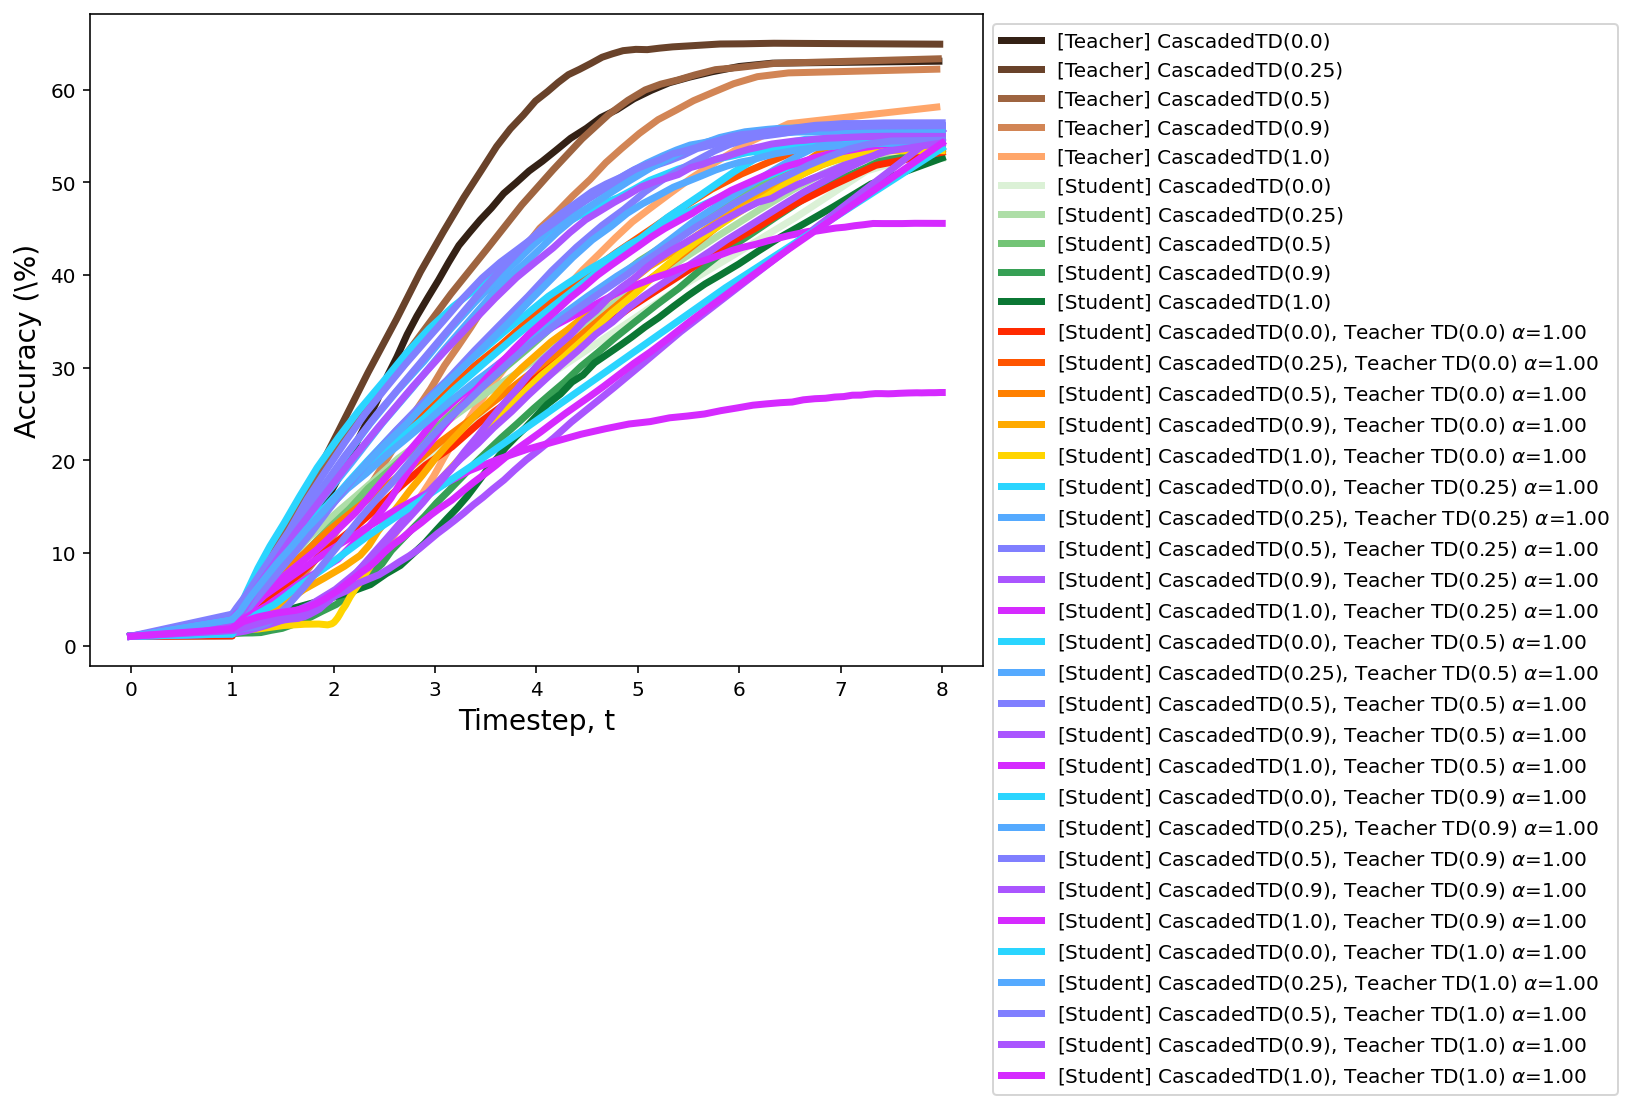

In [414]:
plt.figure(figsize=(8,6))

for mode_key, mode_df in agg_df_src.groupby("exp_mode"):
  if "distillation" in mode_key:
    for teacher_td_lambda, teacher_df in mode_df.groupby("teacher_td_lambda"):
      if teacher_td_lambda == 0.0:
        color_key = "small_distillation_td0"
      else:
        color_key = "small_distillation_td1"
      exp_g = teacher_df.groupby("exp_key")
      colors = cmaps[color_key](np.linspace(0, 1, len(exp_g)+2))[1:-1]
      for i, (exp_key, df_i) in enumerate(exp_g):
        X = df_i.timestep_mean
        y = df_i.acc_mean
        plt.plot(
          X,
          y,
          lw=LINEWIDTH,
          ls="-",
          color=colors[i],
          label=exp_key,
        )
  else:
    exp_g = mode_df.groupby("exp_key")
    colors = cmaps[mode_key](np.linspace(0, 1, len(exp_g)+2))[1:-1]
    for i, (exp_key, df_i) in enumerate(exp_g):
      X = df_i.timestep_mean
      y = df_i.acc_mean
      plt.plot(
        X,
        y,
        lw=LINEWIDTH,
        ls="-",
        color=colors[i],
        label=exp_key,
      )
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Timestep, t", fontsize=14)
plt.ylabel("Accuracy (\%)", fontsize=14);


## Asymptotic

In [566]:
def create_asymp_df(df):
  save_keys = ["exp_key", "model", "student_td_lambda", "teacher_td_lambda", "alpha", "distillation"]
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    asymp_val = np.array(df_i.acc_mean)[-1]
    df_dict["asymp"].append(asymp_val)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
  asymp_df = pd.DataFrame(df_dict)
  return asymp_df

In [567]:
small_model_df_asymp_df = create_asymp_df(small_model_df)
small_model_df_asymp_df = small_model_df_asymp_df.sort_values(['asymp'], ascending=False).reset_index(drop=True)

In [568]:
large_model_df_asymp_df = create_asymp_df(large_model_df)
large_model_df_asymp_df = large_model_df_asymp_df.sort_values(['asymp'], ascending=False).reset_index(drop=True)

## Heatmap

In [569]:
def annotate_plot(
  g, 
  annot_text,
  annot_x=0.335, 
  annot_y=0.85,
  widthB=8.9,
  annot_lw=3.0,
  annot_color="r",
  text_dy = 0.01,
):

  g.annotate(
    annot_text, 
    xy=(annot_x, annot_y), 
    xytext=(annot_x, annot_y+text_dy), 
    xycoords="axes fraction", 
    fontsize=10, 
    ha="center", 
    va="bottom",
    bbox=dict(
      boxstyle="square", 
      fc="white", 
      color=annot_color, 
      lw=annot_lw
    ),
    arrowprops=dict(
      arrowstyle=f"-[, widthB={widthB}, lengthB=1.5", 
      lw=annot_lw,
      color=annot_color,
    )
  )


In [570]:
large_df = large_model_df_asymp_df[["student_td_lambda", "teacher_td_lambda", "asymp"]]

large_df["teacher_td_lambda"] = [ele for ele in large_df.student_td_lambda]
large_df["student_td_lambda"] = [f"y" for ele in large_df.student_td_lambda]
large_df

asymp_df = pd.concat([small_model_df_asymp_df, large_df])

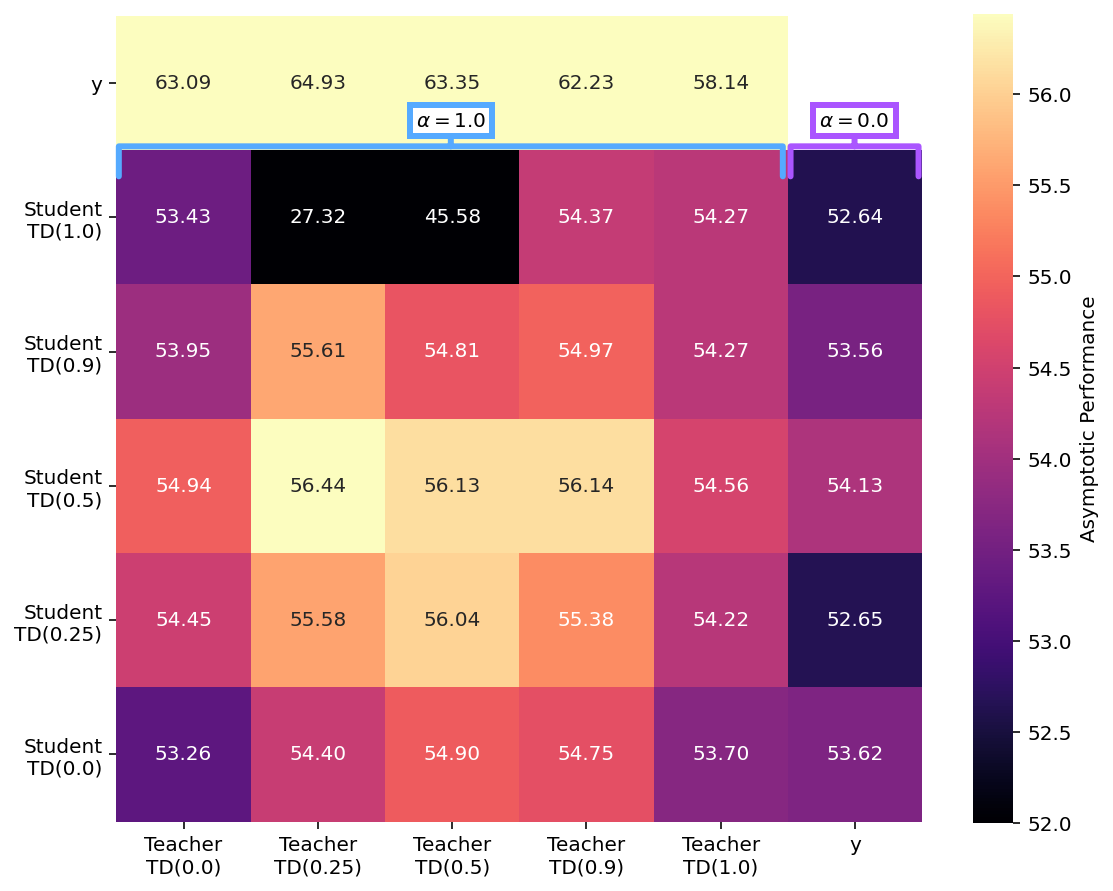

In [630]:
VMIN = 52
# VMAX = 60
CBAR_SHRINK_FACTOR = 0.73
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
result = asymp_df.pivot(
  index="teacher_td_lambda", 
  columns="student_td_lambda", 
  values="asymp"
).T


# Resort columns
cols = np.roll(result.columns.tolist(), -1)
result = result[cols]

# Resort rows
result = result.iloc[::-1]
result = result.loc[result.index]

VMAX = result.iloc[1:].values.max()

# Fix xtick and ytick labels
fix_x_ele = lambda x: f"Teacher\nTD({x})" if x >=0 else r"y"
fix_y_ele = lambda x: f"Student\nTD({x})" if x != "y" else x
xtick_labels = [fix_x_ele(ele) for ele in result.columns.to_list()]
ytick_labels = [fix_y_ele(ele) for ele in result.index.to_list()]  # [::-1]

# Mask
mask = np.zeros_like(result)
mask[np.where(result==0)] = True


g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.2f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Asymptotic Performance", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)
g.set_xticklabels(xtick_labels)
g.set_yticklabels(ytick_labels)
g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)
plt.tight_layout()


annot_y = 0.833
text_dy = 0.025
annot_cmap = plt.cm.cool(np.linspace(0, 1, 2+2))[1:-1]
annot_color = "gray"
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=1.0$", 
  annot_x=0.415, 
  annot_y=annot_y, 
  widthB=16.6,
  annot_color=annot_cmap[0],
  text_dy=text_dy,
)
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=0.0$", 
  annot_x=0.916, 
  annot_y=annot_y, 
  widthB=3.2,
  annot_color=annot_cmap[1],
  text_dy=text_dy,
)
pdf_save_path = os.path.join(figs_root, "asymptotic_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

### AUC Compute

In [631]:
def create_auc_df(df):
  save_keys = ["exp_key", "model", "student_td_lambda", "teacher_td_lambda", "alpha", "distillation"]
  df_dict = defaultdict(list)
  for exp_key, df_i in df.groupby("exp_key"):
    Xs = np.array(df_i.timestep_mean)
    vals = np.array(df_i.acc_mean)
    norm = [100 for _ in vals]
    auc_val = np.trapz(vals, Xs) / np.trapz(norm, Xs)
    df_dict["auc"].append(auc_val)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
  auc_df = pd.DataFrame(df_dict)
  return auc_df

In [657]:
small_auc_df = create_auc_df(small_model_df)
small_auc_df = small_auc_df.sort_values(['auc'], ascending=False).reset_index(drop=True)

In [658]:
large_auc_df = create_auc_df(large_model_df)
large_auc_df = large_auc_df.sort_values(['auc'], ascending=False).reset_index(drop=True)

In [659]:
large_df_auc = large_auc_df[["student_td_lambda", "teacher_td_lambda", "auc"]]

large_df_auc["teacher_td_lambda"] = [ele for ele in large_df_auc.student_td_lambda]
large_df_auc["student_td_lambda"] = [f"y" for ele in large_df_auc.student_td_lambda]

auc_df = pd.concat([small_auc_df, large_df_auc])

In [660]:
bad_idx_1 = auc_df[(auc_df.student_td_lambda==0.25)&(auc_df.teacher_td_lambda==0.9)].index
bad_idx_2 = auc_df[(auc_df.student_td_lambda==0.9)&(auc_df.teacher_td_lambda==0.5)].index
bad_idx_3 = auc_df[(auc_df.student_td_lambda==0.0)&(auc_df.teacher_td_lambda==0.25)].index
bad_idx_4 = auc_df[(auc_df.student_td_lambda=="y")&(auc_df.teacher_td_lambda==0.5)].index

In [661]:
auc_df.loc[bad_idx_1, "auc"] = 0.329
auc_df.loc[bad_idx_2, "auc"] = 0.285
auc_df.loc[bad_idx_3, "auc"] = 0.355
# auc_df.loc[bad_idx_4, "auc"] = 0.382

### Heatmap

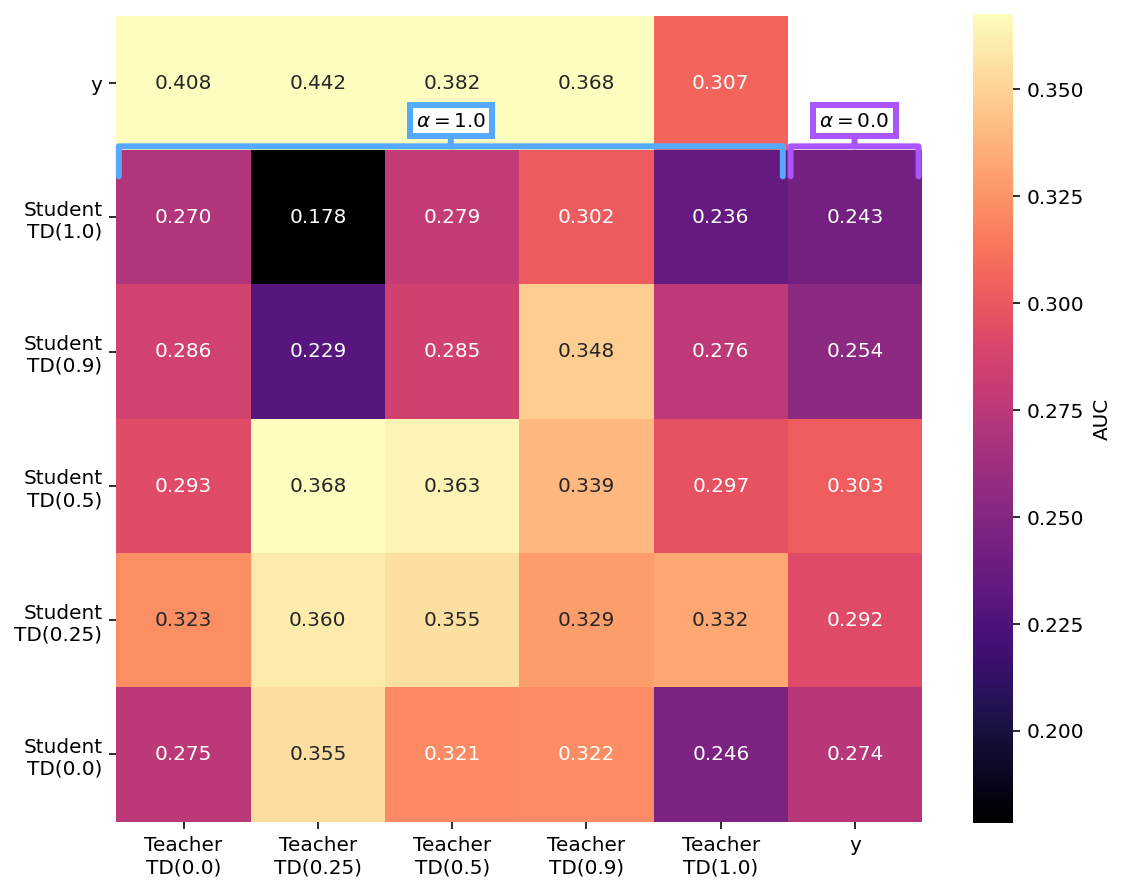

In [664]:
VMIN = None
VMAX = 0.38
CBAR_SHRINK_FACTOR = 0.73
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
result = auc_df.pivot(
  index="teacher_td_lambda", 
  columns="student_td_lambda", 
  values="auc"
).T

# Resort columns
cols = np.roll(result.columns.tolist(), -1)
result = result[cols]

# Resort rows
result = result.iloc[::-1]
result = result.loc[result.index]

# FIX
result.loc["y", 0.5] = 0.382

VMAX = result.iloc[1:].values.max()

# Fix xtick and ytick labels
fix_x_ele = lambda x: f"Teacher\nTD({x})" if x >=0 else r"y"
fix_y_ele = lambda x: f"Student\nTD({x})" if x != "y" else x
xtick_labels = [fix_x_ele(ele) for ele in result.columns.to_list()]
ytick_labels = [fix_y_ele(ele) for ele in result.index.to_list()]  # [::-1]

# Mask
mask = np.zeros_like(result)
mask[np.where(result==0)] = True


g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.3f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "AUC", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)
g.set_xticklabels(xtick_labels)
g.set_yticklabels(ytick_labels)
g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)
plt.tight_layout()


annot_y = 0.833
text_dy = 0.025
annot_cmap = plt.cm.cool(np.linspace(0, 1, 2+2))[1:-1]
annot_color = "gray"
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=1.0$", 
  annot_x=0.415, 
  annot_y=annot_y, 
  widthB=16.6,
  annot_color=annot_cmap[0],
  text_dy=text_dy,
)
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=0.0$", 
  annot_x=0.916, 
  annot_y=annot_y, 
  widthB=3.2,
  annot_color=annot_cmap[1],
  text_dy=text_dy,
)
pdf_save_path = os.path.join(figs_root, "auc_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

## TD Curves

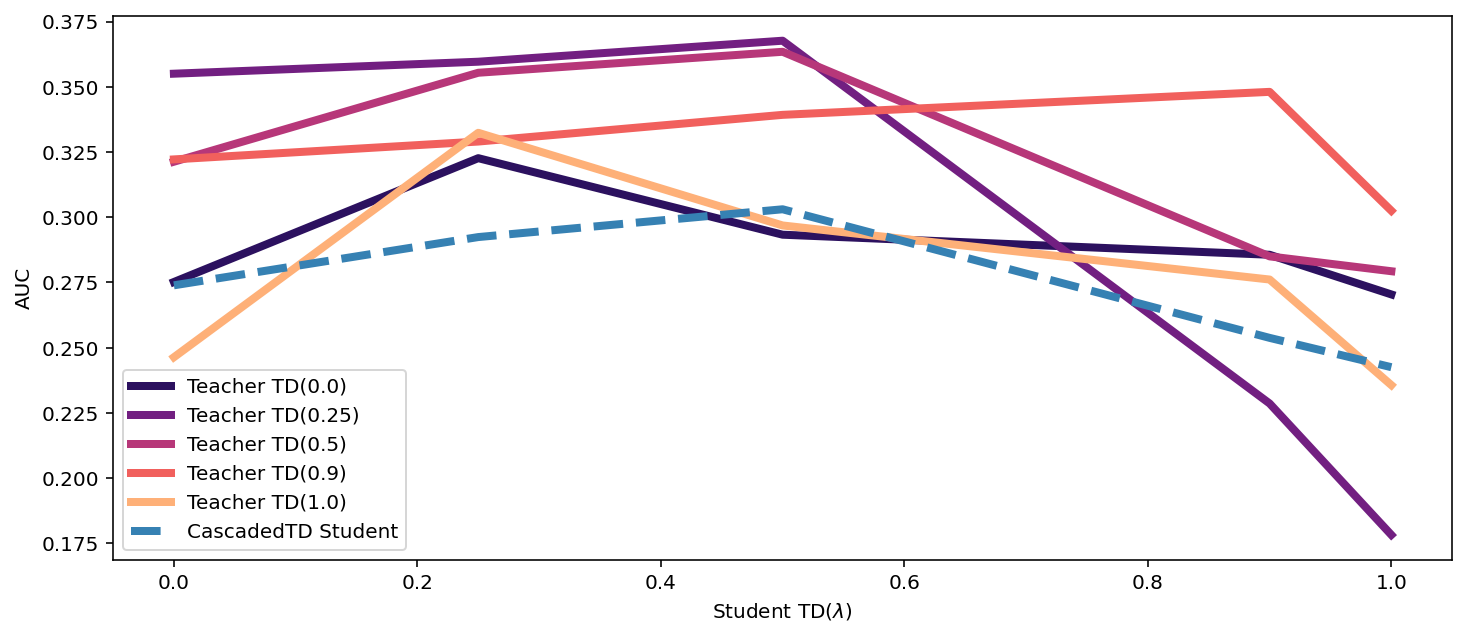

In [665]:
td_curves = result.iloc[1:].T.iloc[:-1]
td_curves = td_curves[td_curves.columns[::-1]]
plt.figure(figsize=(12,5))
lw = 4
cmap = plt.cm.magma(np.linspace(0, 1, len(td_curves)+2))[1:-1]
for i, (teacher_td, td_data) in enumerate(td_curves.iterrows()):
  teacher_td = f"Teacher TD({teacher_td})"
  plt.plot(
    td_data,
    label=teacher_td,
    c=cmap[i],
    lw=lw,
  )
  
# Without distillation
student_td_y = result[result.columns[-1]][::-1][:-1]
plt.plot(
  student_td_y, 
  label="CascadedTD Student",
  lw=lw,
  ls="--",
  color=casc_seq_color,
)
  
plt.xlabel(r"Student TD($\lambda$)")
plt.ylabel("AUC")
plt.legend()

## Correlation

In [721]:
dfv1 = asymp_df[["asymp", "exp_key"]].dropna()
dfv1.reset_index(drop=True, inplace=True)

In [722]:
dfv2 = auc_df[["auc", "exp_key"]].dropna()
dfv2.reset_index(drop=True, inplace=True)

In [738]:
df_list = []
for exp_key in dfv1.exp_key.unique():
  df_i = dfv1[dfv1.exp_key == exp_key]
  df_j = dfv2[dfv2.exp_key == exp_key][["auc"]]
  df_i.reset_index(drop=True, inplace=True)
  df_j.reset_index(drop=True, inplace=True)
  df_k = pd.concat([df_i, df_j], axis=1)[["asymp", "auc", "exp_key"]]
  df_list.append(df_k)
corr_df = pd.concat(df_list)

In [740]:
corr_df["asymp"].corr(corr_df["auc"])

0.589419778278147

## Time Cost

In [ ]:
betas = np.arange(0, 4, 0.1)
save_keys = ["exp_key", "model", "td_lambda", "alpha", "distillation"]
df_dict = defaultdict(list)
for exp_key, df_i in agg_df.groupby("exp_key"):
  Xs = np.array(df_i.timestep_mean)
  vals = np.array(df_i.acc_mean)
  for beta in betas:
    costs = []
    ts = range(len(Xs)-1)
    for t in ts:
      dx = Xs[t+1] - Xs[t]
      dy = vals[t+1] - vals[t]
      cost_i = dy * dx / ((t+1) ** beta)
      costs.append(cost_i)
    
    norm = [100 for _ in costs]
    auc = np.trapz(costs, ts) / np.trapz(norm, ts)
    df_dict["cost"].append(np.sum(costs))
    df_dict["auc"].append(auc)
    df_dict["beta"].append(beta)
    for key in save_keys:
      df_dict[key].append(df_i.iloc[0][key])
new_df = pd.DataFrame(df_dict)

In [ ]:
df_list = []
for (model, td_lambda, beta), df_i in new_df.groupby(["model", "td_lambda", "beta"]):
  df_j = df_i.agg(np.mean).to_frame().T
  sem_df = df_i.agg(np.std).to_frame().T
  sem_cost = sem_df.iloc[0].cost / np.sqrt(len(df_i))
  sem_auc = sem_df.iloc[0].auc / np.sqrt(len(df_i))
  df_j.drop(columns=["alpha"], inplace=True)
  if model == "cascaded_seq":
    exp_key = "CascadedSeq"
  else:
    exp_key = f"CascadedTD({td_lambda})"
  df_j["sem_cost"] = sem_cost
  df_j["sem_auc"] = sem_auc
  df_j["model"] = model
  df_j["td_lambda"] = td_lambda
  df_j["exp_key"] = exp_key
  df_list.append(df_j)
alpha_agg_df = pd.concat(df_list)
alpha_agg_df.reset_index(drop=True, inplace=True)

In [ ]:
for key in ["auc", "cost"]:
  for beta, df_i in alpha_agg_df.groupby("beta"):
    max_val = df_i[key].max()
    min_val = df_i[key].min()
    norm_fxn = lambda x: (x - min_val) / (max_val - min_val)
    relative_val = [norm_fxn(ele) for ele in df_i[key]]
    alpha_agg_df.loc[df_i.index, f"relative_{key}"] = relative_val

In [ ]:
cmaps = {
  "cascaded": plt.cm.magma,
  "cascaded_seq": plt.cm.cool,
}
colors = {}
for model, df_i in agg_df.groupby("model"):
  cmap = cmaps[model]
  n_colors = len(df_i.groupby("td_lambda"))
  colors[model] = cmap(np.linspace(0, 1, n_colors+2))[1:-1]

plot_df = alpha_agg_df[alpha_agg_df.beta >= 1]
plt.figure(figsize=(12,6))
unique_td_lambdas = plot_df.td_lambda.unique()
unique_td_lambdas = list(unique_td_lambdas[unique_td_lambdas >= 0])
seen_labels = []
for i, (exp_key, df_i) in enumerate(plot_df.groupby("exp_key")):
  model_key = df_i.iloc[0].model
  td_lambda = df_i.iloc[0].td_lambda
  if model_key == "cascaded":
    idx = np.where(unique_td_lambdas==td_lambda)[0][0]
    color = colors[model_key][idx]
    ls = "-"
    label = f"TD({td_lambda})"
  else:
    color = CASCADED_SEQ_COLOR
    ls = "--"
    label = "CascadedSeq"
  if label in seen_labels:
    label = None
  seen_labels.append(label)
  plt.plot(
    list(df_i.beta),
    list(df_i.relative_cost),
    label=label,
    ls=ls,
    color=color,
    lw=4,
  )
  
#   yerr_1 = np.array(df_i.relative_cost) - np.array(df_i.sem_cost)
#   yerr_2 = np.array(df_i.relative_cost) + np.array(df_i.sem_cost)
#   plt.fill_between(
#     list(df_i.beta),
#     yerr_1,
#     yerr_2,
#     alpha=0.15,
#     color=color,
#   )
  
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={"size": 12})
plt.xlabel(r"$\beta$", fontsize=14)
plt.ylabel("Relative Performance", fontsize=14);

plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "relative_cost.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)